<a href="https://colab.research.google.com/github/PATELOM925/Automated_Sleep_Staging_Techniques/blob/main/5CLASS_40_SUBJECTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n\nIf running on Google Colab, you can request a GPU runtime by'
          ' clicking\n`Runtime/Change runtime type` in the top bar menu, then '
          'selecting \'GPU\'\nunder \'Hardware accelerator\'.')


CUDA-enabled GPU found.


In [7]:
!pip install mne
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 49.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl

In [8]:
import os
import copy
import mne
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline



# enable GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [70]:
import os

base_dir = '/content/drive/MyDrive/sleepData/sleep_data/'
all_files = os.listdir(base_dir)

psg_files = sorted([f for f in all_files if 'PSG.edf' in f])[:40]
hypnogram_files = sorted([f for f in all_files if 'Hypnogram.edf' in f])[:40]

fnames = [(os.path.join(base_dir, psg), os.path.join(base_dir, hypnogram))
          for psg, hypnogram in zip(psg_files, hypnogram_files)]

for psg, hypnogram in fnames:
    print(f"PSG: {psg}, Hypnogram: {hypnogram}")


PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4001E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4001EC-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4002E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4002EC-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4011E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4011EH-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4012E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4012EC-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4021E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4021EH-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4022E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4022EJ-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4031E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4031EC

In [75]:
fnames

[('/content/drive/MyDrive/sleepData/sleep_data/SC4001E0-PSG.edf',
  '/content/drive/MyDrive/sleepData/sleep_data/SC4001EC-Hypnogram.edf'),
 ('/content/drive/MyDrive/sleepData/sleep_data/SC4002E0-PSG.edf',
  '/content/drive/MyDrive/sleepData/sleep_data/SC4002EC-Hypnogram.edf'),
 ('/content/drive/MyDrive/sleepData/sleep_data/SC4011E0-PSG.edf',
  '/content/drive/MyDrive/sleepData/sleep_data/SC4011EH-Hypnogram.edf'),
 ('/content/drive/MyDrive/sleepData/sleep_data/SC4012E0-PSG.edf',
  '/content/drive/MyDrive/sleepData/sleep_data/SC4012EC-Hypnogram.edf'),
 ('/content/drive/MyDrive/sleepData/sleep_data/SC4021E0-PSG.edf',
  '/content/drive/MyDrive/sleepData/sleep_data/SC4021EH-Hypnogram.edf'),
 ('/content/drive/MyDrive/sleepData/sleep_data/SC4022E0-PSG.edf',
  '/content/drive/MyDrive/sleepData/sleep_data/SC4022EJ-Hypnogram.edf'),
 ('/content/drive/MyDrive/sleepData/sleep_data/SC4031E0-PSG.edf',
  '/content/drive/MyDrive/sleepData/sleep_data/SC4031EC-Hypnogram.edf'),
 ('/content/drive/MyDrive/s

In [85]:
len(fnames)

40

In [ ]:
# fnames = [
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4002E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4002EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4011E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4011EH-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4012E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4012EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4021E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4021EH-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4022E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4022EJ-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4031E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4031EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4032E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4032EP-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4041E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4041EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4042E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4042EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4051E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4051EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4052E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4052EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4061E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4061EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4062E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4062EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4071E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4071EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4072E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4072EH-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4081E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4081EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4082E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4082EP-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4091E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4091EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4092E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4092EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4101E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4101EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4102E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4102EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4111E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4111EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4112E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4112EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4121E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4121EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4122E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4122EV-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4131E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4131EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4141E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4141EU-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4142E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4142EU-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4151E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4151EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4152E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4152EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4161E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4161EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4162E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4162EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4171E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4171EU-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4172E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4172EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4181E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4181EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4182E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4182EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4191E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4191EP-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4192E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4192EV-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4201E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4201EC-Hypnogram.edf')




# ]


In [76]:
# def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True,
#                              crop_wake_mins=30):

#     mapping = {'EOG horizontal': 'eog',
#                'Resp oro-nasal': 'misc',
#                'EMG submental': 'misc',
#                'Temp rectal': 'misc',
#                'Event marker': 'misc'}
#     exclude = mapping.keys() if load_eeg_only else ()

#     raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
#     annots = mne.read_annotations(annot_fname)
#     raw.set_annotations(annots, emit_warning=False)
#     if not load_eeg_only:
#         raw.set_channel_types(mapping)

#     if crop_wake_mins > 0:  # Cut start and end Wake periods
#         # Find first and last sleep stages
#         mask = [x[-1] in ['1', '2', '3', '4', 'R']
#                 for x in annots.description]
#         sleep_event_inds = np.where(mask)[0]

#         # Crop raw
#         max_time = (raw.n_times - 1) / raw.info['sfreq']
#         #print(max_time)
#         tmin = annots[int(sleep_event_inds[0])]['onset'] - \
#                crop_wake_mins * 60
#         tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
#                crop_wake_mins * 60
#         if tmin >= 0 and tmax <= max_time:   # data preprocessing removing tmax (%s) which are grater than or equal to the max
#             raw.crop(tmin=tmin, tmax=tmax)
#         else:
#             pass

#     # Rename EEG channels
#     ch_names = {i: i.replace('EEG ', '')
#                 for i in raw.ch_names if 'EEG' in i}
#     mne.rename_channels(raw.info, ch_names)

#     # Save subject and recording information in raw.info
#     basename = os.path.basename(raw_fname)
#     subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
#     raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}

#     return raw

# Function to load and process files
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, crop_wake_mins=30):
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()

    try:
        raw = mne.io.read_raw_edf(raw_fname, exclude=exclude, preload=True)
        annots = mne.read_annotations(annot_fname)
        raw.set_annotations(annots, emit_warning=False)
        if not load_eeg_only:
            raw.set_channel_types(mapping)

        if crop_wake_mins > 0:  # Cut start and end Wake periods
            # Find first and last sleep stages
            mask = [x[-1] in ['1', '2', '3', '4', 'R']
                    for x in annots.description]
            sleep_event_inds = np.where(mask)[0]

            #crop raw
            max_time = (raw.n_times - 1) / raw.info['sfreq']
            #print(max_time)
            tmin = annots[int(sleep_event_inds[0])]['onset'] - \
                  crop_wake_mins * 60
            tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
                  crop_wake_mins * 60
            if tmin >= 0 and tmax <= max_time:   # data preprocessing removing tmax (%s) which are grater than or equal to the max
                raw.crop(tmin=tmin, tmax=tmax)
              # max_time = (raw.n_times - 1) / raw.info['sfreq']
              # tmin = annots[int(sleep_event_inds[0])]['onset'] - crop_wake_mins * 60
              # tmax = annots[int(sleep_event_inds[-1])]['onset'] + crop_wake_mins * 60
              # if tmin >= 0 and tmax <= max_time:  # Check tmin and tmax validity
              #     raw.crop(tmin=tmin, tmax=tmax)
            else:
                  print("Invalid crop times for", raw_fname)

        # Rename EEG channels
        ch_names = {i: i.replace('EEG ', '') for i in raw.ch_names if 'EEG' in i}
        mne.rename_channels(raw.info, ch_names)

        # Save subject and recording information in raw.info
        basename = os.path.basename(raw_fname)
        subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
        raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}

        return raw
    except Exception as e:
        print(f"Error loading file {raw_fname}:", e)
        return None


In [84]:
len(raws)

20

In [57]:
# #data_loading
# raws=[load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames if f[0] and f[1]]
raws = [raw for raw in raws if raw is not None]

Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sl

In [69]:
print(raws[19])

<RawEDF | SC4092E0-PSG.edf, 2 x 3345001 (33450.0 s), ~51.0 MB, data loaded>


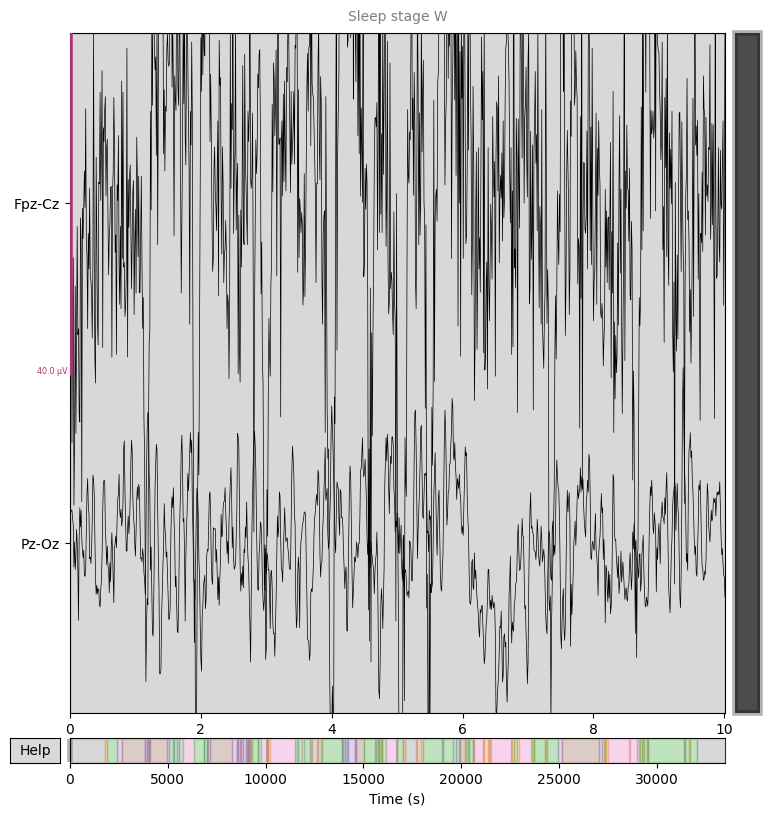

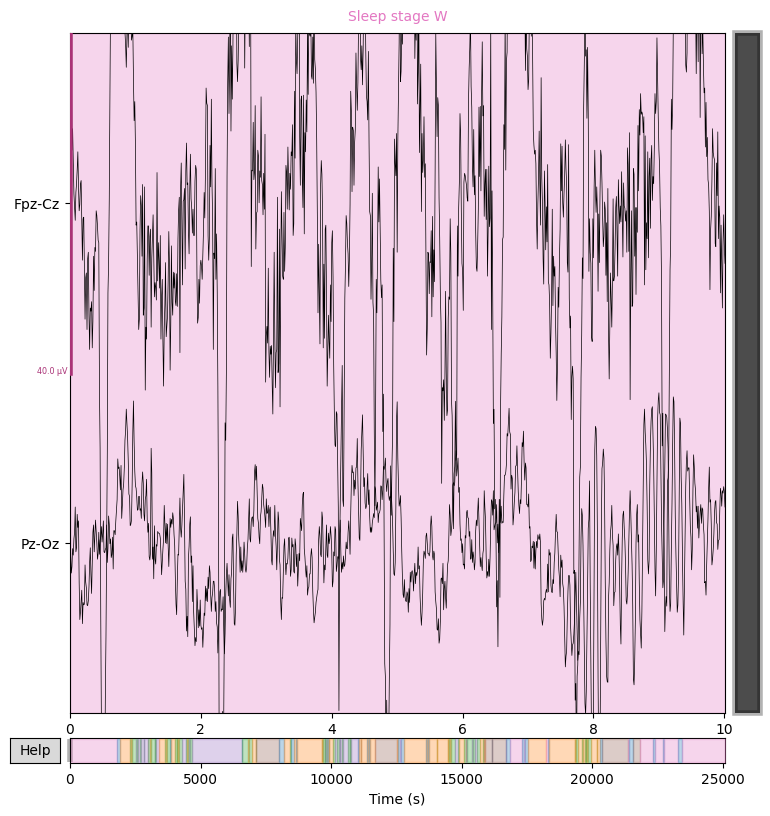

In [88]:
# Plot a recording as a sanity check
raws[1].plot();
raws[0].plot();

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter paramet

<ipython-input-89-ef74459ef080>:5: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raws[0].plot_psd();
<ipython-input-89-ef74459ef080>:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raws[0].plot_psd();


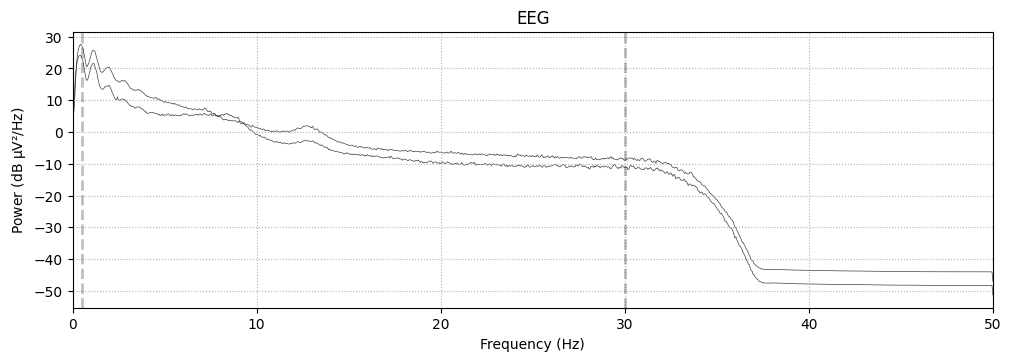

In [89]:
# Applying high pass filter.
l_freq, h_freq = None, 30 # Allowing frequencies below 30 Hz to pass through while attenuating frequencies above 30 Hz.


for raw in raws:
    raw.load_data().filter(l_freq, h_freq)
raws[0].plot_psd();

In [95]:
# function to extract 30-s windows

def extract_epochs(raw, chunk_duration=30.):

    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,
        'Sleep stage 4': 4,
        'Sleep stage R': 5}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id,
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        'Sleep stage R': 5}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)

    return epochs.get_data(), epochs.events[:, 2] - 1

In [96]:
# wrap arounfd around pytorch dataset class
from torch.utils.data import Dataset, ConcatDataset

class EpochsDataset(Dataset):

    def __init__(self,epochs_data, epochs_labels, subj_nb=None, rec_nb=None, transform =None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data =epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform
    def __len__(self):
        return len(self.epochs_labels)
    def __getitem__(self,idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y

#Standard scaling of data
def scale(X):

    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

In [97]:

raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

# If you want to test with only two datasets
raws_exc = [raws[1]]  # Remove the dataset you want to exclude
all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'], rec_nb=raw.info['subject_info']['rec_id'], transform=scale)
                for i, raw in enumerate(raws) if i not in raws_exc]

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)


Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sl

<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1115 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1115 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1087 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1087 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1149 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1020 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1020 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1008 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1008 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
950 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 950 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
902 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 902 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1234 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1234 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1198 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1198 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
670 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 670 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1245 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1245 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
827 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 827 events and 3000 original time points ...


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1012 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1012 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
969 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 969 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1271 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1271 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1127 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1127 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1053 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1053 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1130 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1130 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1103 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1097 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1097 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1087 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1087 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
924 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 924 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
788 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 788 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1049 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1049 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
972 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 972 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1024 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1024 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1003 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1003 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
948 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 948 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
940 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 940 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1752 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1752 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1139 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1139 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1002 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1002 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
951 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 951 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1770 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1770 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
941 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 941 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
917 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 917 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1523 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1523 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1243 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1243 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


1005 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1005 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-95-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


In [98]:
from sklearn.model_selection import LeavePGroupsOut


def pick_recordings(dataset, subj_rec_nbs):

    pick_idx = []
    for subj_nb, rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)

    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)

    pick_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        remaining_ds = None

    return pick_ds, remaining_ds


def train_test_split(dataset, n_groups, split_by='subj_nb'):

    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])

    return train_ds, test_ds

In [99]:
# We seed the random number generators to make our splits reproducible
torch.manual_seed(103)
np.random.seed(103)

In [100]:
# Use recording 1 of subjects 0-19 as test set
test_recs = [(subj_nb, rec_nb)  #
             for subj_nb, rec_nb in zip(range(20), [1] * 10)]
test_ds, train_ds = pick_recordings(dataset, test_recs)

In [101]:
# Split remaining recordings into training and validation sets
n_subjects_valid = max(1, int(len(train_ds.datasets) * 0.2))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')

print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

Number of examples in each set:
Training: 26514
Validation: 6617
Test: 9850


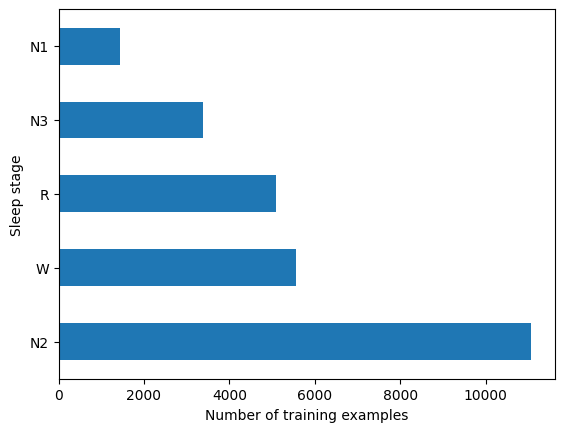

In [102]:
classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of training examples');
ax.set_ylabel('Sleep stage');

In [103]:
# Computing class weight
from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
print(class_weights)

[0.95528734 3.6621547  0.47941416 1.57213163 1.04365282]


In [105]:
from torch import nn


class SleepStagerChambon2018(nn.Module):

    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):

        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

In [106]:
# hyperperameters
dropout=0.75
lr=1e-3

In [107]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels

model = SleepStagerChambon2018(n_channels, sfreq, n_classes=5,dropout=dropout)

In [108]:
model = model.to(device)

In [109]:
from torch.utils.data import DataLoader

# Create dataloaders
train_batch_size = 128  # Important hyperparameter
valid_batch_size = 250  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

In [110]:
# functions to carry out our training and validation loops:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()

    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = [], []
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()

        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()

    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(train_loss), perf


def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()

    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = [], []
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()

            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())

    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs,
          patience, device, metric=None):

    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = []

    if metric is None:
        metric = balanced_accuracy_score

    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch,
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})

        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

In [111]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

In [112]:
n_epochs =11 #10
patience =11 #10
best_model, history = train(model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience,
                                 device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------
1 	 1.2296 	 0.9813 	 0.3104 	 0.5133
best val loss inf -> 0.9813
2 	 0.8607 	 0.8742 	 0.5601 	 0.5252
best val loss 0.9813 -> 0.8742
3 	 0.7871 	 0.8064 	 0.6159 	 0.6232
best val loss 0.8742 -> 0.8064
4 	 0.7619 	 0.8139 	 0.6320 	 0.5699
5 	 0.7327 	 0.8076 	 0.6529 	 0.5848
6 	 0.7253 	 0.7653 	 0.6531 	 0.6438
best val loss 0.8064 -> 0.7653
7 	 0.7133 	 0.7714 	 0.6592 	 0.6197
8 	 0.7125 	 0.7610 	 0.6679 	 0.6379
best val loss 0.7653 -> 0.7610
9 	 0.7006 	 0.7720 	 0.6695 	 0.6261
10 	 0.6990 	 0.7620 	 0.6735 	 0.6540
11 	 0.7011 	 0.7717 	 0.6738 	 0.6259


In [113]:
best_epoch_index = max(range(len(history)), key=lambda i: history[i]['valid_perf'])
best_epoch_info = history[best_epoch_index]
best_epoch_performance = best_epoch_info['valid_perf']

# Print the results
print(f"Best Epoch Index: {best_epoch_index}")
print(f"Best Validation Performance: {best_epoch_performance}")

Best Epoch Index: 9
Best Validation Performance: 0.6540466961441549


In [117]:
# Compute test performance

best_model.eval()

y_pred_all, y_true_all = [], []
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())

y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])

test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_kappa = cohen_kappa_score(y_true, y_pred)

In [118]:
print(f'Test balanced accuracy: {test_bal_acc:0.3f}')
print(f'Test Cohen\'s kappa: {test_kappa:0.3f}')

Test balanced accuracy: 0.755
Test Cohen's kappa: 0.692


In [119]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = [key for key in classes_mapping.keys()]
    tick_labels = classes_mapping.values()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(conf_mat, cmap='Greens')

    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion matrix')

    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, conf_mat[i, j], ha='center', va='center', color='k')

    fig.colorbar(im, ax=ax, fraction=0.05, label='# examples')
    fig.tight_layout()

    return fig, ax

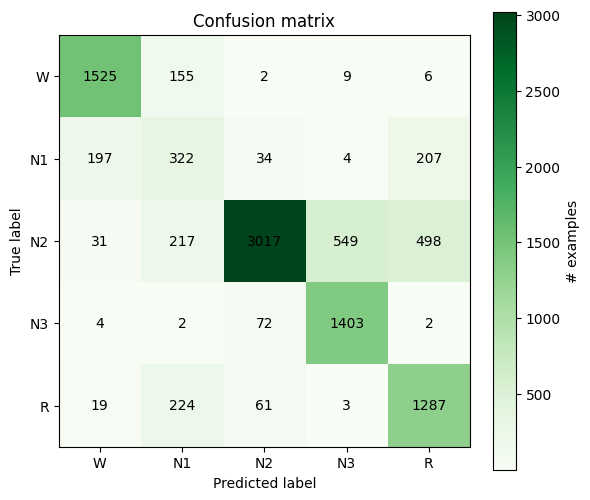

In [120]:
conf_mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat, classes_mapping);

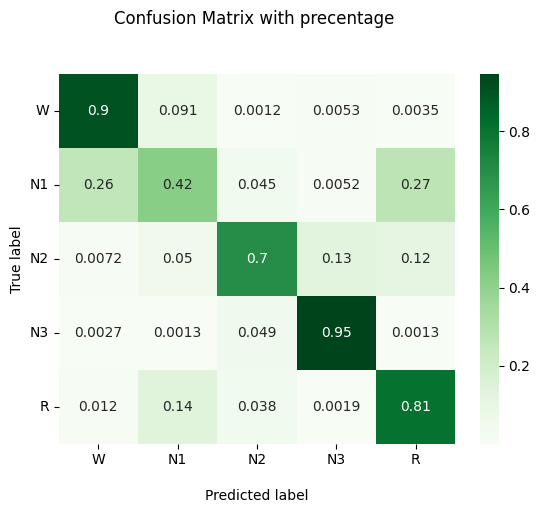

In [121]:
import seaborn as sns
x_axis_labels=["W", "N1", 'N2','N3','R']
y_axis_labels =["W", 'N1', 'N2','N3','R']

ax = sns.heatmap(conf_mat/conf_mat.sum(axis=1)[:, np.newaxis], annot=True,  cmap='Greens',xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 10)
ax.set_title('Confusion Matrix with precentage \n\n');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');


## Display the visualization of the Confusion Matrix.
plt.show()

In [122]:
from sklearn import metrics
target_names = ['W', 'N1', 'N2','N3','R']
print(metrics.classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           W       0.86      0.90      0.88      1697
          N1       0.35      0.42      0.38       764
          N2       0.95      0.70      0.80      4312
          N3       0.71      0.95      0.81      1483
           R       0.64      0.81      0.72      1594

    accuracy                           0.77      9850
   macro avg       0.70      0.75      0.72      9850
weighted avg       0.80      0.77      0.77      9850



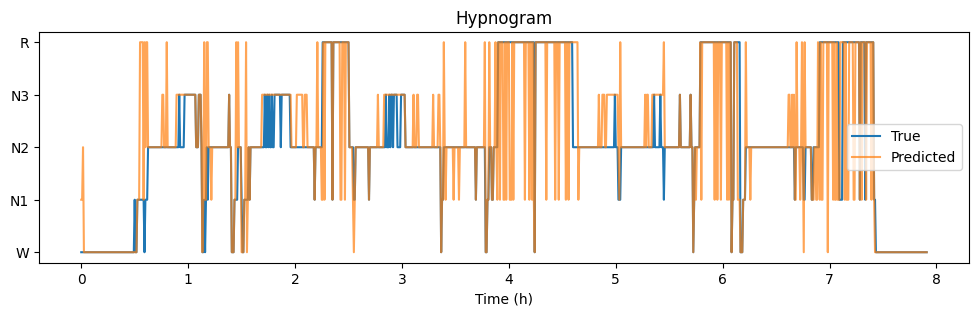

In [124]:
# Plot hypnogram for one recording

mask = rec_ids == 3  # pick a recording number

t = np.arange(len(y_true[mask])) * 30 / 3600

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, y_true[mask], label='True')
ax.plot(t, y_pred[mask], alpha=0.7, label='Predicted')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['W', 'N1', 'N2', 'N3', 'R'])
ax.set_xlabel('Time (h)')
ax.set_title('Hypnogram')
ax.legend();

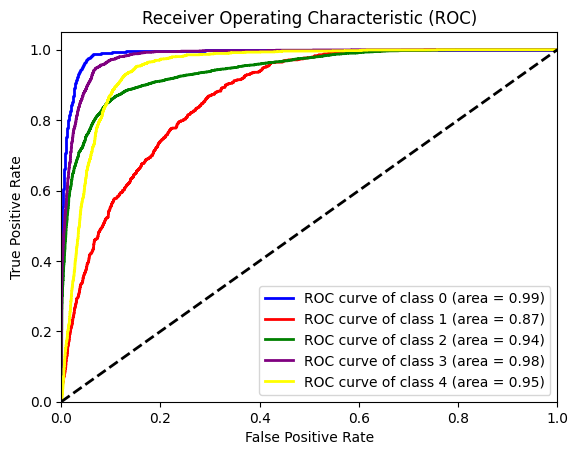

In [125]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer


model.eval()  # Set model to evaluation mode

softmax = nn.Softmax(dim=1)
y_true_list = []
y_pred_probs_list = []

with torch.no_grad():
    for batch_x, batch_y in loader_test:
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        output = softmax(model.forward(batch_x)).cpu().numpy()  # Get probability predictions
        y_pred_probs_list.append(output)
        y_true_list.append(batch_y.cpu().numpy())

y_pred_probs = np.concatenate(y_pred_probs_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# Binarize the true labels (y_true) for all classes
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)  # Transform multi-class labels to binary labels

# Calculate the ROC curve and ROC area for each class
n_classes = y_true_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curve for each class
colors = ['blue', 'red', 'green', 'purple','yellow']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [126]:
from sklearn.metrics import roc_auc_score
# Assuming y_true and y_pred_probs are already defined and contain true labels and prediction probabilities respectively

n_classes = y_true_bin.shape[1]

# Binarize the output labels
y_true_binarized = LabelBinarizer().fit_transform(y_true)

# Calculate AUC for each class and print
for i in range(n_classes):
    class_auc = roc_auc_score(y_true_binarized[:, i], y_pred_probs[:, i])
    print(f"Class {i} AUC: {class_auc:.3f}")

# Calculate and print micro-average AUC score across all classes
micro_avg_auc = roc_auc_score(y_true_binarized, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_avg_auc:.3f}")

# Calculate and print macro-average AUC score across all classes
macro_avg_auc = roc_auc_score(y_true_binarized, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_avg_auc:.3f}")


Class 0 AUC: 0.990
Class 1 AUC: 0.866
Class 2 AUC: 0.942
Class 3 AUC: 0.981
Class 4 AUC: 0.947
Micro-average AUC: 0.949
Macro-average AUC: 0.945


In [127]:
import torch.nn.functional as F

def evaluate_model(model, loader, device):
    model.eval()  # Set model to evaluation mode
    true_labels = []
    predictions = []
    with torch.no_grad():  # No need to track gradients
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            output = model(batch_x)
            probs = F.softmax(output, dim=1)  # Convert logits to probabilities
            predictions.append(probs.cpu().numpy())
            true_labels.append(batch_y.cpu().numpy())

    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    return true_labels, predictions

# After training your model, evaluate it to get true labels and predicted probabilities
y_true, y_pred_probs = evaluate_model(best_model, loader_test, device)


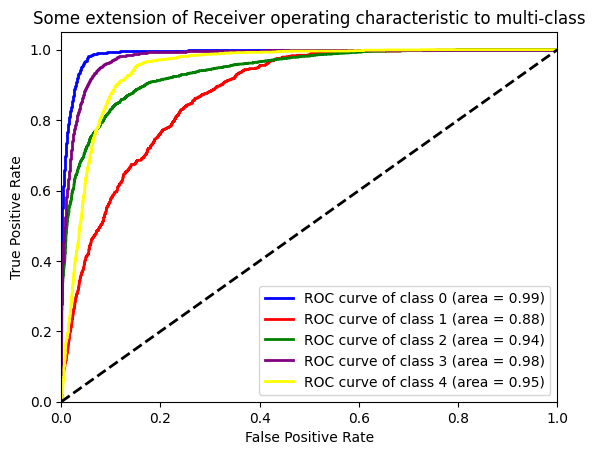

In [130]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

def plot_multiclass_roc_auc(y_true, y_score, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    colors = cycle(['blue', 'red', 'green', 'purple','yellow','darkorange'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

# Call the plotting function with the number of classes
plot_multiclass_roc_auc(y_true, y_pred_probs, n_classes=5)


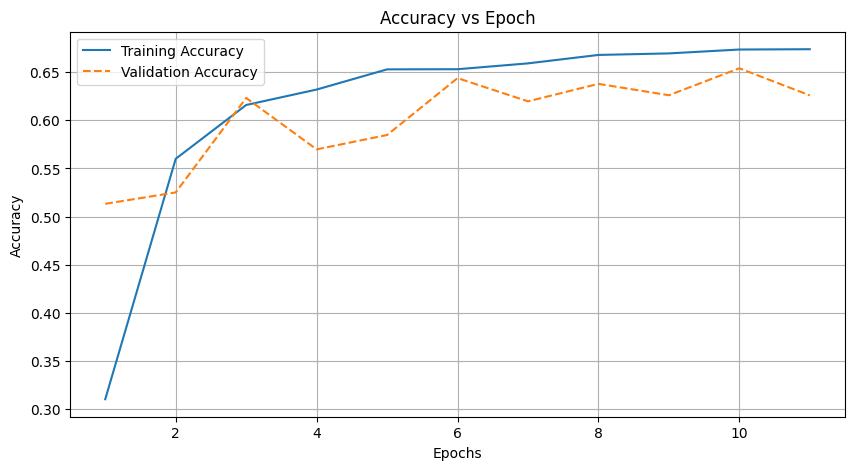

In [131]:
import matplotlib.pyplot as plt

epochs = [x['epoch'] for x in history]
train_perfs = [x['train_perf'] for x in history]
valid_perfs = [x['valid_perf'] for x in history]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_perfs, label='Training Accuracy')
plt.plot(epochs, valid_perfs, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


1 	 0.6917 	 0.7673 	 0.6795 	 0.6064
2 	 0.6795 	 0.7335 	 0.6850 	 0.6725
3 	 0.6830 	 0.7664 	 0.6816 	 0.6556
4 	 0.6709 	 0.7705 	 0.6878 	 0.6212
5 	 0.6780 	 0.7631 	 0.6839 	 0.6704
6 	 0.6751 	 0.7275 	 0.6864 	 0.6163
7 	 0.6603 	 0.7345 	 0.6910 	 0.6822
8 	 0.6635 	 0.7265 	 0.6934 	 0.6586
9 	 0.6634 	 0.7398 	 0.6927 	 0.6374
10 	 0.6596 	 0.7632 	 0.6897 	 0.6403
11 	 0.6565 	 0.7227 	 0.6922 	 0.6886


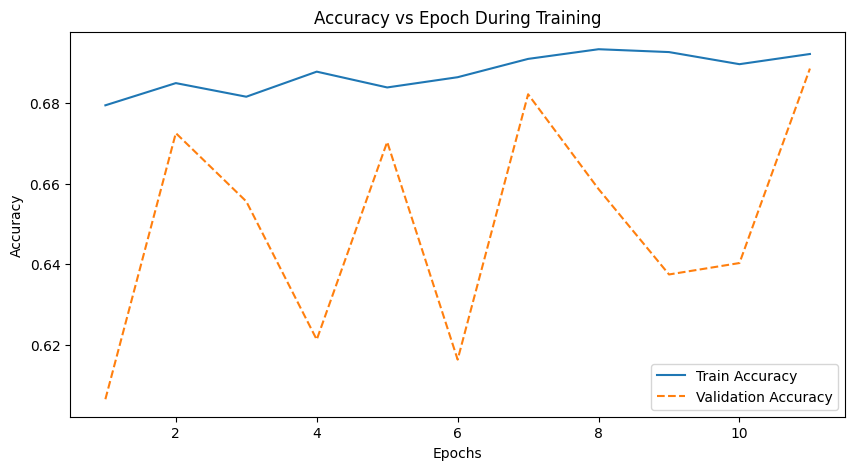

In [132]:
import matplotlib.pyplot as plt

def train_and_plot(model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience, device, metric=None):
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = []

    if metric is None:
        metric = balanced_accuracy_score

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append({
            'epoch': epoch,
            'train_loss': train_loss, 'valid_loss': valid_loss,
            'train_perf': train_perf, 'valid_perf': valid_perf})

        print(f'{epoch} \t {train_loss:.4f} \t {valid_loss:.4f} \t {train_perf:.4f} \t {valid_perf:.4f}')

        # Model improvement check
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # Early stopping check
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss: {best_valid_loss:.4f}')
            break

    # Accuracy vs Epoch Plot
    epochs = [x['epoch'] for x in history]
    train_accs = [x['train_perf'] for x in history]
    valid_accs = [x['valid_perf'] for x in history]

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, valid_accs, label='Validation Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')  # Update this if you use metrics other than accuracy
    plt.title('Accuracy vs Epoch During Training')
    plt.legend()
    plt.show()

    return best_model, history

# Update model training call
best_model, training_history = train_and_plot(model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience, device, metric=cohen_kappa_score)



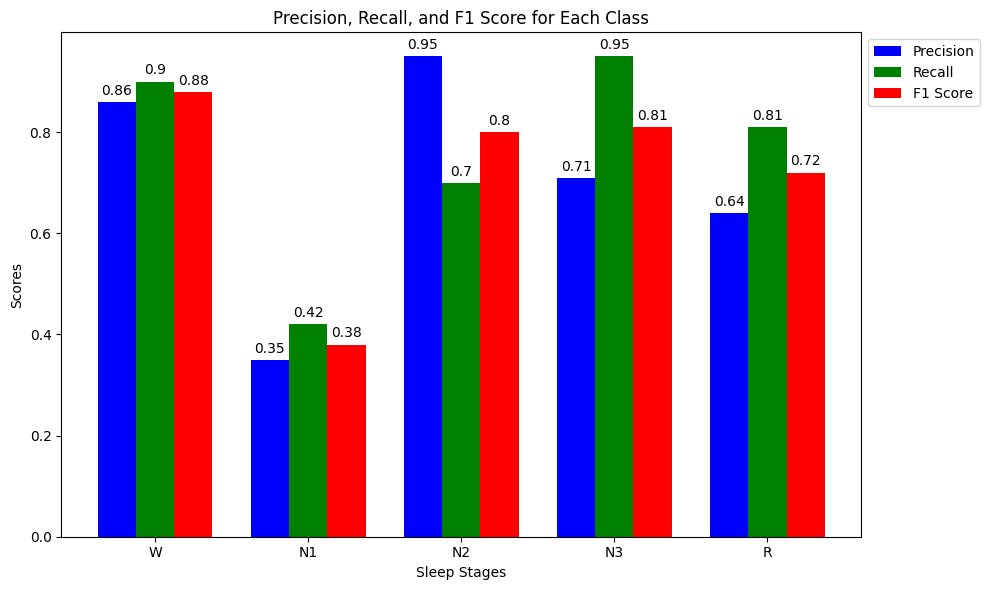

In [133]:
import numpy as np
import matplotlib.pyplot as plt

# Extracted values from your classification report
precision = [0.86, 0.35, 0.95, 0.71, 0.64]
recall = [0.9, 0.42, 0.70, 0.95,0.81]
f1_score = [0.88, 0.38, 0.8, 0.81, 0.72]
classes = ['W', 'N1','N2', 'N3', 'R']


# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
index = np.arange(len(classes))

# Plot bars for each metric
bar1 = ax.bar(index, precision, bar_width, label='Precision', color='b')
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall', color='g')
bar3 = ax.bar(index + 2*bar_width, f1_score, bar_width, label='F1 Score', color='r')

# Add aesthetics
ax.set_xlabel('Sleep Stages')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score for Each Class')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)

# Change legend location to right outside the chart
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

# Helper function to attach a text label above each bar
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

plt.tight_layout()
plt.show()


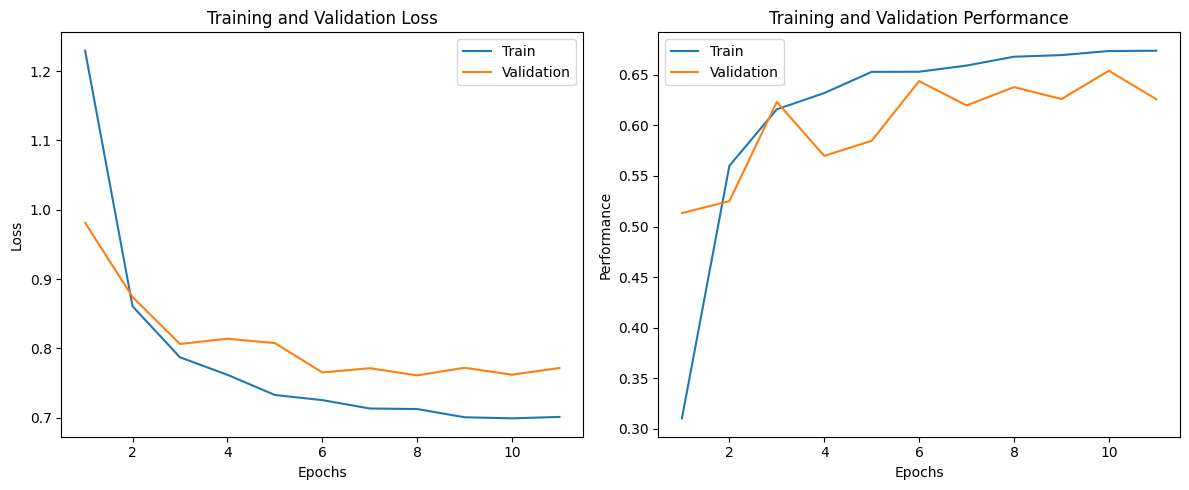

In [134]:
import matplotlib.pyplot as plt

# Extract history information
epochs = [entry['epoch'] for entry in history]
train_losses = [entry['train_loss'] for entry in history]
valid_losses = [entry['valid_loss'] for entry in history]
train_perfs = [entry['train_perf'] for entry in history]
valid_perfs = [entry['valid_perf'] for entry in history]

# Plotting
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, valid_losses, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Performance plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_perfs, label='Train')
plt.plot(epochs, valid_perfs, label='Validation')
plt.title('Training and Validation Performance')
plt.xlabel('Epochs')
plt.ylabel('Performance')
plt.legend()

plt.tight_layout()
plt.show()


In [136]:
# Add this code after computing y_true and y_pred
import random

sample_indices = random.sample(range(len(y_true)), min(5, len(y_true)))
for idx in sample_indices:
    print(f"Example {idx + 1} - True: {classes_mapping[y_true[idx]]}, Predicted: {classes_mapping[y_pred[idx]]}")


Example 3784 - True: R, Predicted: R
Example 7831 - True: W, Predicted: W
Example 2789 - True: R, Predicted: R
Example 3603 - True: N2, Predicted: N2
Example 4039 - True: N2, Predicted: N2
